In [2]:
from qiskit import *
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram
import numpy as np
%matplotlib inline

### Multiplier

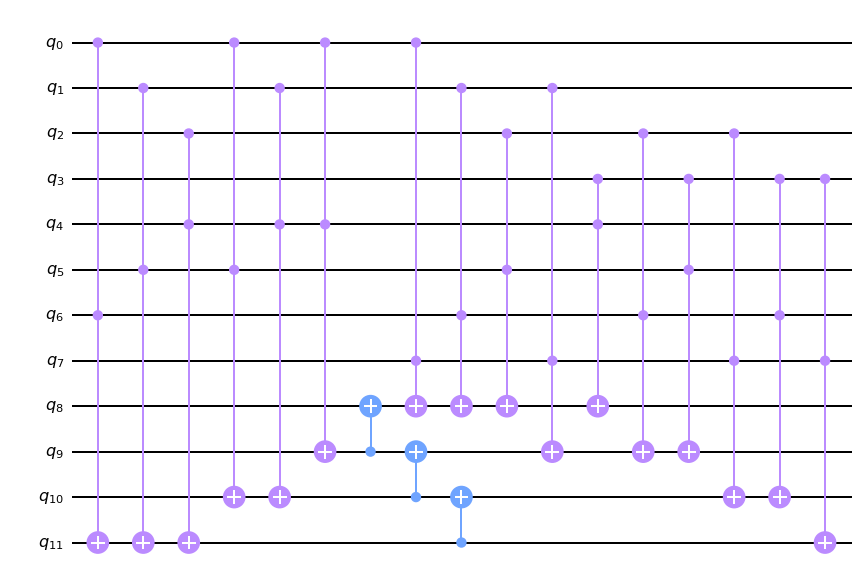

In [3]:
mul = QuantumCircuit(12)
qubits = [
    [0,6,11],
    [1,5,11],
    [2,4,11],
    [0,5,10],
    [1,4,10],
    [0,4,9],
    [9,8],
    [10,9],
    [11,10],
    [0,7,8],
    [1,6,8],
    [2,5,8],
    [3,4,8],
    [1,7,9],
    [2,6,9],
    [3,5,9],
    [2,7,10],
    [3,6,10],
    [3,7,11]
]


for i in qubits:
    if len(i) == 3:
        mul.toffoli(i[0],i[1],i[2])
    else:
        mul.cnot(i[0],i[1])

mul.draw('mpl')

In [4]:
mul_gate = mul.to_gate()
mul_gate.name = 'Multiplier'

### Squarer

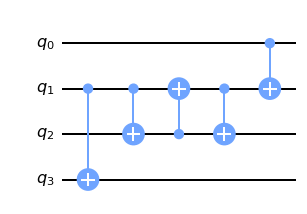

In [5]:
sq = QuantumCircuit(4)
qubits = [
    [1,3],
    [1,2],
    [2,1],
    [1,2],
    [0,1]
]
for i in qubits:
    sq.cnot(i[0],i[1])
sq.draw('mpl')

In [6]:
sq_gate = sq.to_gate()
sq_gate.name = 'Squarer'

### Affine

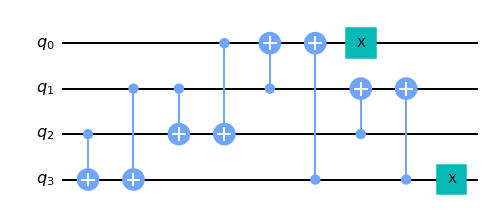

In [7]:
affine = QuantumCircuit(4)
qubits = [
    [2,3],
    [1,3],
    [1,2],
    [0,2],
    [1,0],
    [3,0],
    [2,1],
    [3,1]
]
for i in qubits:
    affine.cnot(i[0],i[1])
affine.x(0)
affine.x(3)
affine.draw('mpl')

In [8]:
affine_gate = affine.to_gate()
affine_gate.name = 'Affine'

### Sbox

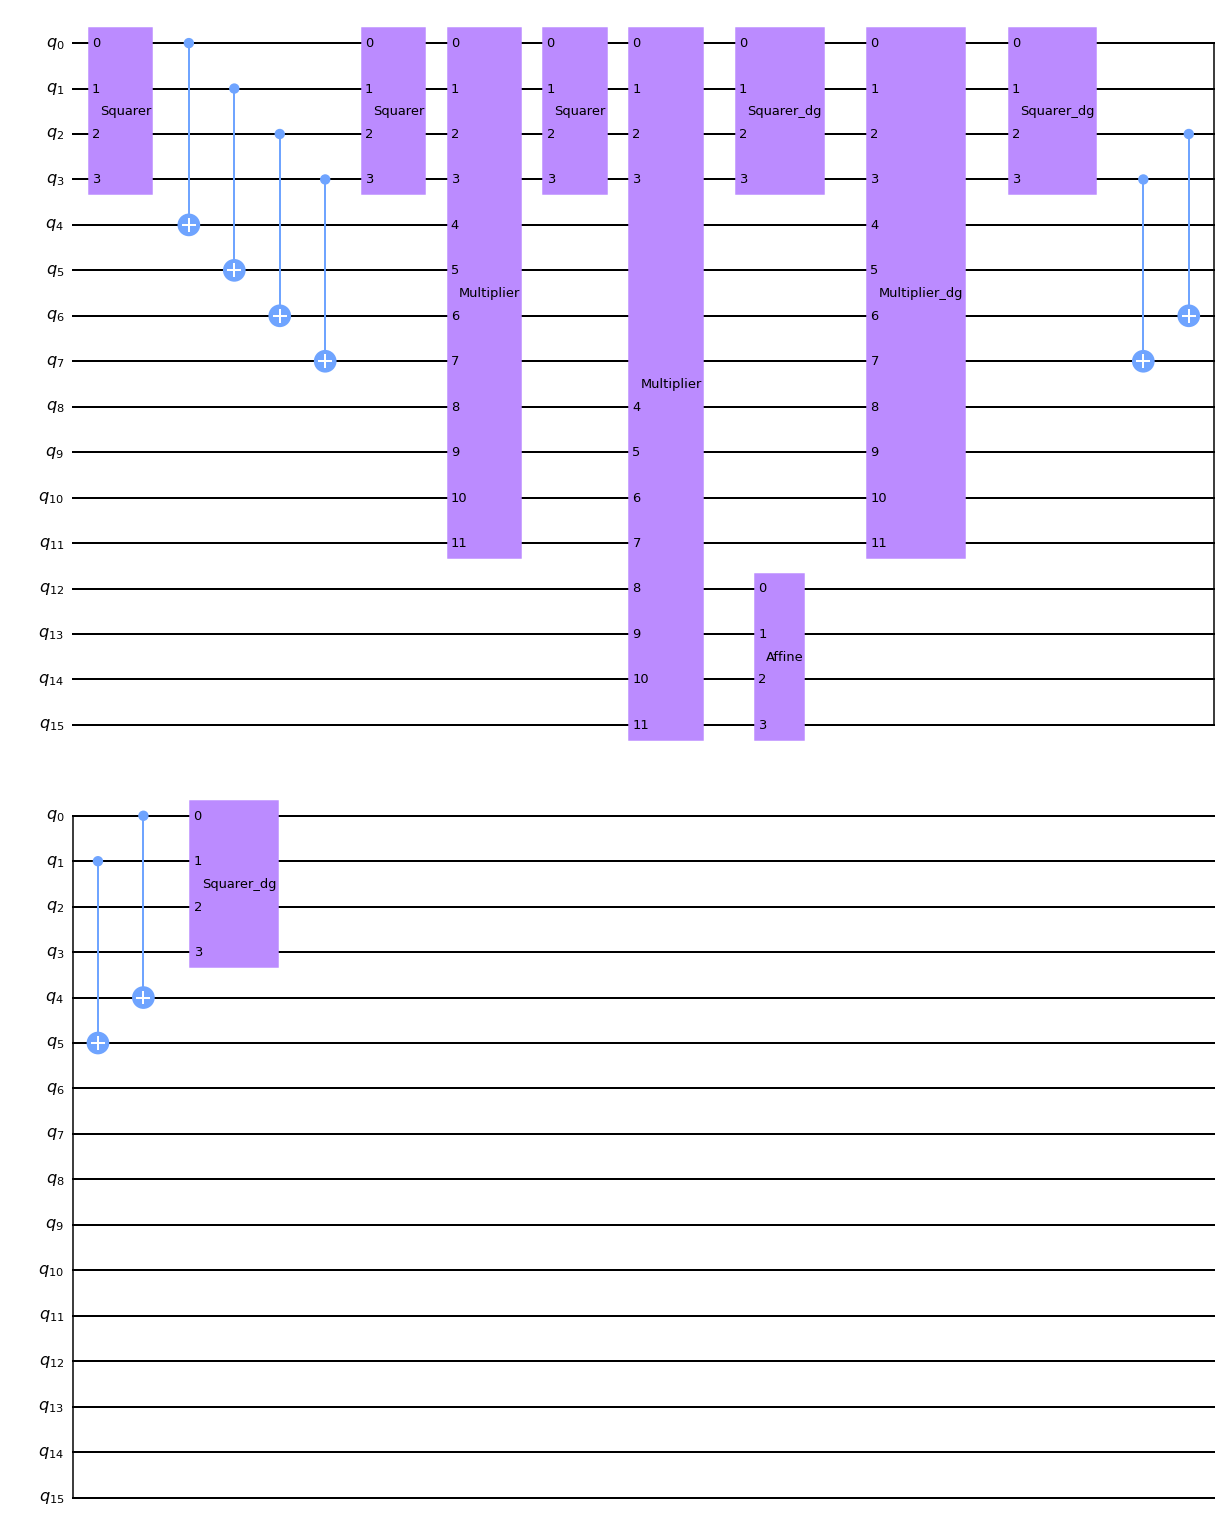

In [9]:
sbox = QuantumCircuit(16)
sbox.append(sq_gate,range(4))
sbox.cnot(0,4)
sbox.cnot(1,5)
sbox.cnot(2,6)
sbox.cnot(3,7)
sbox.append(sq_gate,range(4))
sbox.append(mul_gate,range(12))
sbox.append(sq_gate,range(4))
sbox.append(mul_gate,[0,1,2,3,8,9,10,11,12,13,14,15])
sbox.append(sq_gate.inverse(),range(4))
sbox.append(mul_gate.inverse(),range(12))
sbox.append(sq_gate.inverse(),range(4))
sbox.cnot(3,7)
sbox.cnot(2,6)
sbox.cnot(1,5)
sbox.cnot(0,4)
sbox.append(sq_gate.inverse(),range(4))
sbox.append(affine_gate,range(12,16))
sbox.draw('mpl')

In [10]:
shots = 1000
simulator = Aer.get_backend('qasm_simulator')

for i in range(16):
    
    num = bin(i)[2:][::-1]
    qc = QuantumCircuit(16,4)
    
    for index, j in enumerate(num):
        if j == '1':
            qc.x(3 - index)
            
    qc = qc.compose(sbox,range(16))
    qc.measure(range(12,16), range(0,4))
    
    res = execute(qc,backend=simulator, shots=shots).result()
    counts = res.get_counts(qc)
    print(i, int(list(counts.keys())[0][::-1], 2))
    
    del qc

0 9
1 4
2 10
3 11
4 13
5 1
6 8
7 5
8 6
9 2
10 0
11 3
12 12
13 14
14 15
15 7


In [11]:
sbox_gate = sbox.to_gate()
sbox_gate.name = 'SN'

### MC

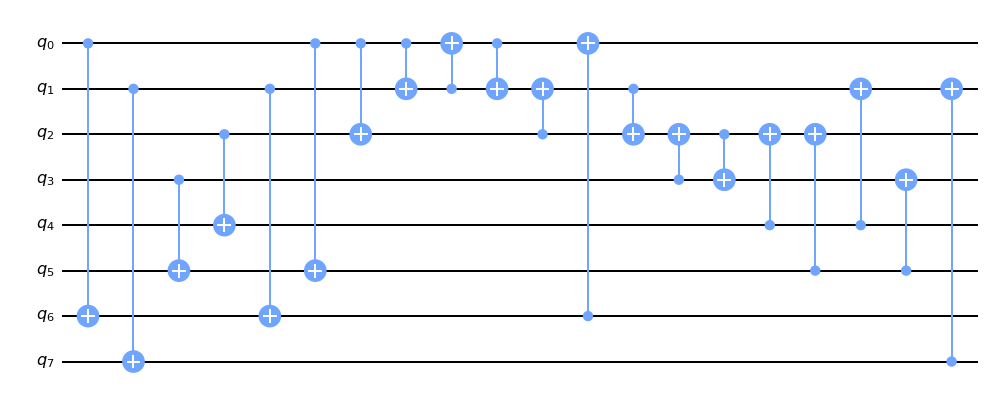

In [24]:
mc = QuantumCircuit(8)
qubits = [
    [0,6],
    [1,7],
    [1,6],
    [3,5],
    [2,4],
    [0,5],
    [0,2],
    [0,1],
    [1,0],
    [0,1],
    [2,1],
    [1,2],
    [3,2],
    [2,3],
    [4,2],
    [5,2],
    [4,1],
    [5,3],
    [6,0],
    [7,1]
]
for i in qubits:
    mc.cnot(i[0],i[1])

mc.draw('mpl')

In [28]:
mix_col = np.array([[1, 4], [4, 1]])

def galoisMult(b, a):
    p = 0
    hiBitSet = 0
    for i in range(4):
        if b & 1 == 1:
            p ^= a
        a <<= 1
        hiBitSet = a & 0x10
        if hiBitSet:
            a ^= 0x13
        b >>= 1
    return p

def mix_column(state):
    res = np.zeros((2, 2)).astype(int)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                res[i][j] ^= galoisMult(mix_col[i][k],state[k][j])
    return res

In [38]:
state = np.zeros((2,2)).astype(int)
count = 0
for i in range(16):
    state[0][0] = i
    for j in range(16):
        state[1][0] = j
        mc_state = mix_column(state)
        actual = ((mc_state[0][0] << 12) | (mc_state[1][0] << 8) | (mc_state[0][1] << 4) | mc_state[1][1])
        
        qc = QuantumCircuit(8)
        
        num = ((state[0][0] << 12) | (state[1][0] << 8) | (state[0][1] << 4) | state[1][1])
        num = bin(num)[2:][::-1]
        for index,k in enumerate(num):
            if k == '1':
                qc.x(7-index)
            
        qc = qc.compose(mc, range(8))
        qc.measure_all()
        
        res = execute(qc,backend=simulator, shots=shots).result()
        counts = res.get_counts(qc)
        out = list(counts.keys())[0][::-1] + '00000000'
        out = int(out, 2)
        
#         print(actual,out)
        if actual == out:
            count+=1
        del qc

if count == 16*16:
    print("Verified")

Verified


In [39]:
mc_gate = mc.to_gate()
mc_gate.name = 'MC'

### Round Constants

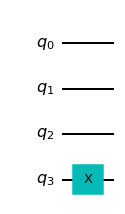

In [46]:
rc1 = QuantumCircuit(4)
rc1.x(3)
rc1.draw('mpl')

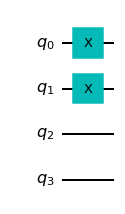

In [47]:
rc2 = QuantumCircuit(4)
rc2.x(0)
rc2.x(1)
rc2.draw('mpl')

In [48]:
rc1_gate = rc1.to_gate()
rc1_gate.name = '$RC_1$'

In [49]:
rc2_gate = rc2.to_gate()
rc2_gate.name = '$RC_2$'

### Proposed quantum circuit of the Simplified-AES

In [13]:
msg = '1101011100101000'
key = '0100101011110101'

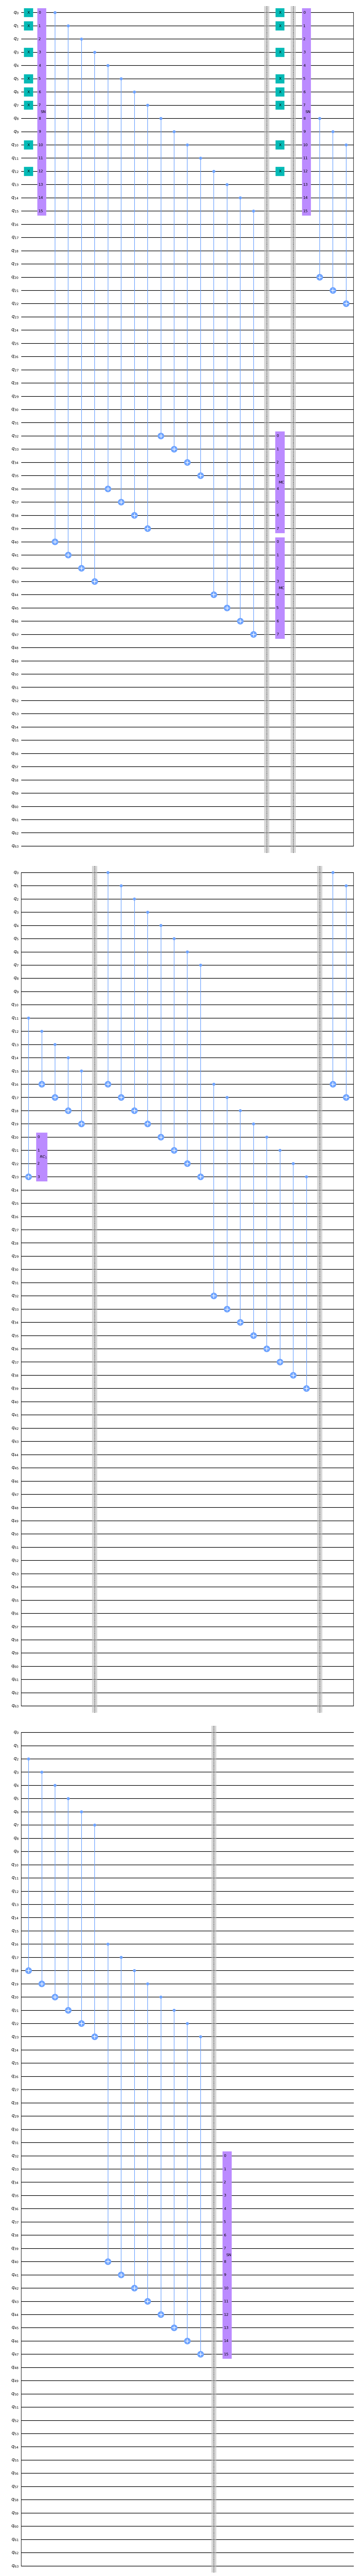

In [53]:
saes = QuantumCircuit(64)

for index, i in enumerate(msg):
    if i == '1':
        saes.x(index)
saes.append(sbox_gate, range(16))

qubits = [
    [0,40],
    [1,41],
    [2,42],
    [3,43],
    
    [4,36],
    [5,37],
    [6,38],
    [7,39],
    
    [8,32],
    [9,33],
    [10,34],
    [11,35],
    
    [12,44],
    [13,45],
    [14,46],
    [15,47]
]

for i in qubits:
    saes.cnot(i[0],i[1])
saes.barrier()
    
for index, i in enumerate(msg):
    if i == '1':
        saes.x(index)

saes.append(mc_gate, range(32,40))
saes.append(mc_gate, range(40,48))
saes.barrier()

saes.append(sbox_gate, range(16))

qubits = [
    [8,20],
    [9,21],
    [10,22],
    [11,23],
    
    [12,16],
    [13,17],
    [14,18],
    [15,19],
]

for i in qubits:
    saes.cnot(i[0],i[1])

saes.append(rc1_gate, range(20,24))
saes.barrier()

qubits = [
    [0,16],
    [1,17],
    [2,18],
    [3,19],
    
    [4,20],
    [5,21],
    [6,22],
    [7,23],
    
    [16,32],
    [17,33],
    [18,34],
    [19,35],
    
    [20,36],
    [21,37],
    [22,38],
    [23,39]
]

for i in qubits:
    saes.cnot(i[0],i[1])
saes.barrier()

qubits = [
    [0,16],
    [1,17],
    [2,18],
    [3,19],
    
    [4,20],
    [5,21],
    [6,22],
    [7,23],
    
    [16,40],
    [17,41],
    [18,42],
    [19,43],
    
    [20,44],
    [21,45],
    [22,46],
    [23,47]
]

for i in qubits:
    saes.cnot(i[0],i[1])
saes.barrier()

saes.append(sbox_gate,range(32,48))

qubits = [
    [32,56],
    [33,57],
    [34,58],
    [35,59],
    
    [36,52],
    [37,53],
    [38,54],
    [39,55],
    
    [40,48],
    [41,49],
    [42,50],
    [43,51],
    
    [44,60],
    [45,61],
    [46,62],
    [47,63]
]

for i in qubits:
    saes.cnot(i[0],i[1])

    
    
saes.barrier()

saes.draw('mpl')